In [57]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
from coffea import processor
import hist
import coffea.nanoevents.methods.vector as vector
import warnings
import matplotlib.pyplot as plt
import math

In [58]:
warnings.filterwarnings("ignore", module="coffea.*")
warnings.filterwarnings("ignore", "Found duplicate branch")
warnings.filterwarnings("ignore", "Missing cross-reference index for")
warnings.filterwarnings("ignore", "dcut")
warnings.filterwarnings("ignore", "Please ensure")
warnings.filterwarnings("ignore", "invalid value")

In [59]:
with open('../../filelists/300to470_files.txt', 'r') as f:
    qcd_files = [line.strip() for line in f]

In [60]:
qcd = NanoEventsFactory.from_root(
    {'/project01/ndcms/cmoore24/qcd/300to470/' + qcd_files[0]: "/Events"},
    delayed=False,
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "300to470"},
).events()

In [61]:
#color ring
def color_ring(fatjet, cluster_val):
    pf = ak.flatten(fatjet.constituents.pf, axis=1)
    jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, cluster_val)
    cluster = fastjet.ClusterSequence(pf, jetdef)
    #subjets = cluster.exclusive_jets(n_jets=3)
    subjets = cluster.inclusive_jets()
    vec = ak.zip(
        {
            "x": subjets.px,
            "y": subjets.py,
            "z": subjets.pz,
            "t": subjets.E,
        },
        with_name="LorentzVector",
        behavior=vector.behavior,
    )
    vec = ak.pad_none(vec, 3)
    vec["norm3"] = np.sqrt(vec.dot(vec))
    vec["idx"] = ak.local_index(vec)
    i, j, k = ak.unzip(ak.combinations(vec, 3))
    #best = ak.argmin(abs((i + j + k).mass - 125), axis=1, keepdims=True)
    best = ak.argmax(abs((i + j + k).pt), axis=1, keepdims=True)
    order_check = ak.concatenate([i[best].pt, j[best].pt, k[best].pt], axis=1)
    largest = ak.argmax(order_check, axis=1, keepdims=True)
    smallest = ak.argmin(order_check, axis=1, keepdims=True)
    leading_particles = ak.concatenate([i[best], j[best], k[best]], axis=1)
    leg1 = leading_particles[largest]
    leg3 = leading_particles[smallest]
    leg2 = leading_particles[
        (leading_particles.idx != ak.flatten(leg1.idx))
        & (leading_particles.idx != ak.flatten(leg3.idx))
    ]
    leg1 = ak.firsts(leg1)
    leg2 = ak.firsts(leg2)
    leg3 = ak.firsts(leg3)
    
    # a12 = np.arccos(leg1.dot(leg2) / (leg1.norm3 * leg2.norm3))
    # a13 = np.arccos(leg1.dot(leg3) / (leg1.norm3 * leg3.norm3))
    # a23 = np.arccos(leg2.dot(leg3) / (leg2.norm3 * leg3.norm3))
    # color_ring = (a13**2 + a23**2) / (a12**2)

    a12 = leg1.delta_r2(leg2)
    a13 = leg1.delta_r2(leg3)
    a23 = leg2.delta_r2(leg3)
    color_ring = (a13 + a23) / (a12)
    
    return ak.Array({"cr":color_ring, "hp0_eta":leg1.eta, "hp1_eta":leg2.eta, "se_eta":leg3.eta,
                    "hp0_phi":leg1.phi, "hp1_phi":leg2.phi, "se_phi":leg3.phi,
                    "hp0_pt":leg1.pt, "hp1_pt":leg2.pt, "se_pt":leg3.pt})

In [62]:
#Make gen particle array
genpart = qcd.GenPart

In [63]:
multiple_children = (ak.num(genpart.children.pdgId, axis=2) >= 2)

In [64]:
pt_cut = ak.max(genpart.pt[multiple_children], axis=1)

In [65]:
cut = ((multiple_children) & (genpart.hasFlags(['isLastCopy'])))

In [66]:
children_sum = (ak.sum(abs(genpart.children.pdgId), axis=2) <= 300)

In [67]:
index = ((genpart.pt == ak.max(genpart[cut].pt, axis=1)) 
         & genpart.hasFlags(['isLastCopy', 'fromHardProcess']) 
         & (multiple_children)
        )

In [68]:
ak.where(ak.is_none(index))

(<Array [32, 56, 67, 70, 83, ..., 24960, 24967, 24986, 24992] type='661 * int64'>,)

In [69]:
leaders = ak.firsts(genpart[index])
cull = ~ak.is_none(leaders)
leaders = ak.drop_none(leaders)

In [70]:
fatjet = qcd.FatJet[cull]
fatjet = fatjet[(qcd.FatJet[cull].pt == ak.max(qcd.FatJet[cull].pt, axis=1))]

In [71]:
cr_arr = color_ring(fatjet, cluster_val=0.2) #output color ring and chosen subjets
uf_cr = ak.unflatten(cr_arr['cr'], counts=ak.num(fatjet)) #unflatten color ring to  event structure
uf_hp0_eta = ak.unflatten(cr_arr['hp0_eta'], counts=ak.num(fatjet))
uf_hp0_phi = ak.unflatten(cr_arr['hp0_phi'], counts=ak.num(fatjet))
uf_hp0_pt = ak.unflatten(cr_arr['hp0_pt'], counts=ak.num(fatjet))
uf_hp1_eta = ak.unflatten(cr_arr['hp1_eta'], counts=ak.num(fatjet))
uf_hp1_phi = ak.unflatten(cr_arr['hp1_phi'], counts=ak.num(fatjet))
uf_hp1_pt = ak.unflatten(cr_arr['hp1_pt'], counts=ak.num(fatjet))
uf_se_eta = ak.unflatten(cr_arr['se_eta'], counts=ak.num(fatjet))
uf_se_phi = ak.unflatten(cr_arr['se_phi'], counts=ak.num(fatjet))
uf_se_pt = ak.unflatten(cr_arr['se_pt'], counts=ak.num(fatjet))

In [72]:
all_vals = ak.zip({'leaders':leaders, 'cr':uf_cr,
        'hp0_eta':uf_hp0_eta, 'hp0_phi':uf_hp0_phi, 'hp0_pt':uf_hp0_pt,
        'hp1_eta':uf_hp1_eta, 'hp1_phi':uf_hp1_phi, 'hp1_pt':uf_hp1_pt,
        'se_eta':uf_se_eta, 'se_phi':uf_se_phi, 'se_pt':uf_se_pt,
       'idx':np.linspace(0, len(fatjet)-1, len(fatjet), dtype='int'),
                  })

In [101]:
choose = 17
cut = ((leaders.pt>300) & 
       (abs(leaders.phi)<1) & 
       (abs(leaders.eta)<2.5))
parent = all_vals['leaders'][cut][choose][0]

In [102]:
xy = np.array([parent.children.eta, parent.children.phi])
midpoint_eta = (xy[0,0] + xy[0,1])/2
midpoint_phi = (xy[1,0] + xy[1,1])/2
radius = math.sqrt((xy[0,1] - xy[0,0])**2 + (xy[1,1] - xy[1,0])**2)/2 #distance formula to find color ring radius 
pt = parent.children.children.pt
#choose leading Pt second gen child
biggest_2 = ak.argmax(pt, axis=1)
use = ak.argmax(ak.Array([pt[0, biggest_2[0]], pt[1, biggest_2[1]]]))
idx = biggest_2[use]
largest_eta = parent.children[use].children[idx].eta
largest_phi = parent.children[use].children[idx].phi
largest_pt = parent.children[use].children[idx].pt

In [103]:
radius

0.009033203125

In [104]:
#Coordinates of the subjets chosen for the color Ring Calculation
hp0_eta = all_vals['hp0_eta'][cut][choose][0]
hp1_eta = all_vals['hp1_eta'][cut][choose][0]
se_eta = all_vals['se_eta'][cut][choose][0]
hp0_phi = all_vals['hp0_phi'][cut][choose][0]
hp1_phi = all_vals['hp1_phi'][cut][choose][0]
se_phi = all_vals['se_phi'][cut][choose][0]

In [105]:
pfcands_eta = fatjet.constituents.pf.eta
pfcands_phi = fatjet.constituents.pf.phi

In [106]:
pfcands_eta = pfcands_eta[all_vals['idx'][cut][choose][0]][0]
pfcands_phi = pfcands_phi[all_vals['idx'][cut][choose][0]][0]

Text(0.5, 1.0, 'Higgs to BB Jet')

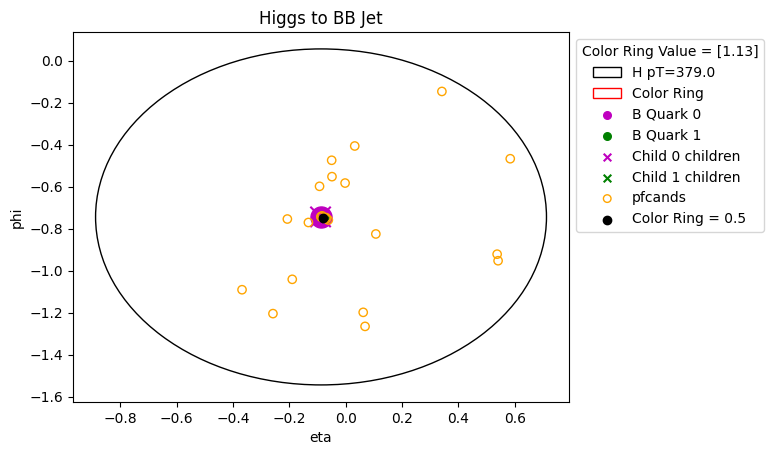

In [107]:
# Gen Particles and children, including the gluon
fig,ax = plt.subplots()
ax.add_patch(plt.Circle((parent.eta, parent.phi), 0.8, facecolor="none", edgecolor="k", label=f"H pT={parent.pt}"))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), radius, facecolor='none', edgecolor='r', label='Color Ring'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.8*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.6*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.4*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.2*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.scatter(parent.children[0].eta, parent.children[0].phi, 
           s=parent.children[0].pt, 
           label="B Quark 0", color='m')
ax.scatter(parent.children[1].eta, parent.children[1].phi, 
           s=parent.children[1].pt, 
           label="B Quark 1", color='g')
ax.scatter(parent.children[0].children.eta, parent.children[0].children.phi, 
           s=parent.children[0].children.pt, 
           marker="x", label="Child 0 children", color='m')
ax.scatter(parent.children[1].children.eta, parent.children[1].children.phi, 
           s=parent.children[1].children.pt, 
           marker="x", label="Child 1 children", color='g')
# ax.scatter(largest_eta, largest_phi, 
#            s=largest_pt, 
#            marker="x", color='b', label='Leading PT 2nd Gen Child')
ax.scatter(pfcands_eta, pfcands_phi, 
#            #s=glu_pt, 
            marker="o", color='orange', label='pfcands',facecolors='none')
ax.scatter(midpoint_eta, midpoint_phi, label='Color Ring = 0.5', color='k')
lgnd = ax.legend(bbox_to_anchor=(1,1), title='Color Ring Value = ' + str(all_vals['cr'][cut][choose]))
lgnd.legend_handles[1]._sizes = [30]
lgnd.legend_handles[2]._sizes = [30]
lgnd.legend_handles[3]._sizes = [30]
lgnd.legend_handles[4]._sizes = [30]
lgnd.legend_handles[5]._sizes = [30]
lgnd.legend_handles[6]._sizes = [30]
plt.xlabel('eta')
plt.ylabel('phi')
plt.title('Higgs to BB Jet')

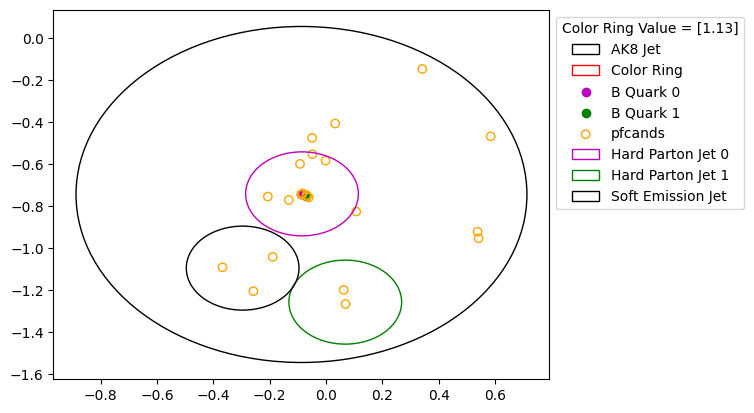

In [108]:
#First gen children and the selected subjets
fig,ax = plt.subplots()
ax.add_patch(plt.Circle((parent.eta, parent.phi), 0.8, facecolor="none", edgecolor="k", label="AK8 Jet"))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), radius, facecolor='none', edgecolor='r', label='Color Ring'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.8*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.6*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.4*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.2*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.scatter(parent.children[0].eta, parent.children[0].phi, 
           #s=higgs.children[0].pt, 
           label="B Quark 0", color='m')
ax.scatter(parent.children[1].eta, parent.children[1].phi, 
           #s=higgs.children[1].pt, 
           label="B Quark 1", color='g')
ax.scatter(pfcands_eta, pfcands_phi, 
#            #s=glu_pt, 
            marker="o", color='orange', label='pfcands',facecolors='none')
ax.add_patch(plt.Circle((hp0_eta, hp0_phi), 0.2, facecolor='none', edgecolor='m', label='Hard Parton Jet 0'))
ax.add_patch(plt.Circle((hp1_eta, hp1_phi), 0.2, facecolor='none', edgecolor='g', label='Hard Parton Jet 1'))
ax.add_patch(plt.Circle((se_eta, se_phi), 0.2, facecolor='none', edgecolor='k', label='Soft Emission Jet'))
lgnd = ax.legend(bbox_to_anchor=(1,1), title='Color Ring Value = ' + str(all_vals['cr'][cut][choose]))